In [82]:
from extractEvents import AnimalEventDetector
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pandas as pd
from pydub import AudioSegment
import os
from scipy.signal import correlate

In [76]:
file_name  = './bird_audio_track.m4a'
amplitude_threshold = 0.05
min_event_duration = 10_000
sample_rate = 44100
band = (370, 400)
ema_alpha=0.01

In [77]:
detector = AnimalEventDetector(amplitude_threshold, min_event_duration, sample_rate, band, ema_alpha)
detector.load_audio(file_name)
events = detector.detect_events(filter=False)
events

[(768362, 1248362), (3360523, 3840523), (8959753, 9439753)]

Text(0.5, 1.0, 'Identifying Bird Activity')

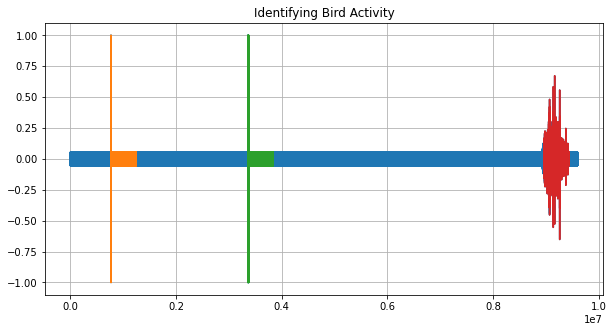

In [79]:
rng = np.arange(detector.audio_array.shape[0])
plt.figure(figsize=(10,5))
plt.plot(rng, detector.audio_array, label='Input Audio Signal')
for event in detector.events:
    plt.plot(rng[event[0]:event[1]], detector.audio_array[event[0]:event[1]])
plt.grid()
plt.title('Identifying Bird Activity')

In [100]:
def load_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    max_amplitude = np.max(np.abs(samples))
    if max_amplitude > 0:
        samples = samples / max_amplitude
    return samples

path = '../data'
correlations = {event[0]: {} for event in detector.events}
normal_correlations = {event[0]: {} for event in detector.events}
filtered_correlations = {event[0]: {} for event in detector.events}
normal_filtered_correlations = {event[0]: {} for event in detector.events}

for file in os.listdir(path):
    animal = file.split('.')[0].replace('_', ' ')
    try:
        sample = load_audio(path+'/'+file)
        sample_filtered = detector.filter_frequencies(sample)
        for event in detector.events:
            signal = detector.audio_array[event[0]:event[1]]
            correlation = correlate(signal, sample, mode='full')
            correlations[event[0]][animal] = np.max(correlation)
            normal_correlations[event[0]][animal] = np.max(correlation)/(np.std(signal)*np.std(sample))

            signal_filtered = detector.filter_frequencies(signal)
            filtered_correlation = correlate(signal_filtered, sample_filtered, mode='full')
            filtered_correlations[event[0]][animal] = np.max(filtered_correlation)
            normal_filtered_correlations[event[0]][animal] = np.max(filtered_correlation)/(np.std(signal_filtered)*np.std(sample_filtered))
    except Exception as e:
        print(e)

Decoding failed. ffmpeg returned error code: 183

Output from ffmpeg/avlib:

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencor

In [101]:
df = pd.DataFrame(correlations)
df.to_csv('../correlations_new.csv')
df_norm = pd.DataFrame(normal_correlations)
df_norm.to_csv('../correlations_new_normal.csv')
df_f = pd.DataFrame(filtered_correlations)
df_f.to_csv('../correlations_new_f.csv')
df_f_norm = pd.DataFrame(normal_filtered_correlations)
df_f_norm.to_csv('../correlations_new_f_normal.csv')

In [112]:
df.idxmax()

768362     Zonotrichia atricapilla
3360523          Catharus guttatus
8959753         Accipiter gentilis
dtype: object

In [113]:
df.sort_values(3360523)

,768362,3360523,8959753
Spinus psaltria,6.323251,8.052062,0.905927
Psiloscops flammeolus,3.849949,18.595196,9.084684
Leucolia violiceps,22.243238,23.664175,4.259813
Scolopax minor,64.470551,26.513483,2.703647
Fulica americana,16.537624,27.008741,9.823241
...,...,...,...
Limosa lapponica,74.392921,340.097046,244.825211
Pyrocephalus obscurus,44.952122,342.152100,139.278885
Accipiter gentilis,34.457268,355.836029,283.182190
Pluvialis dominica,155.119110,359.632324,173.133713


In [114]:
df.loc['Puffinus nativitatis']

768362     30.541933
3360523    41.379639
8959753     8.141680
Name: Puffinus nativitatis, dtype: float32